In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    fowlkes_mallows_score,
    silhouette_score,
)

sns.set(style="whitegrid")
os.makedirs("out", exist_ok=True)

In [14]:
def load_gene_dataset(filepath, delimiter=None):
    """
    Loads a gene expression dataset.
    Format:
    - Column 1: gene_id
    - Column 2: ground truth cluster (-1 = outlier)
    - Columns 3+: expression attributes
    """
    df = pd.read_csv(filepath, sep=delimiter, header=None, engine="python")
    df.columns = ["gene_id", "truth"] + [f"x{i}" for i in range(1, df.shape[1]-1)]
    df["truth"] = df["truth"].astype(int)
    
    X = df.loc[:, df.columns.str.startswith("x")].astype(float).values
    y_true = df["truth"].values
    return df, X, y_true

In [15]:
def run_clustering_algorithms(X_scaled, n_clusters):
    models = {
        "KMeans": KMeans(n_clusters=n_clusters, random_state=42, n_init=20),
        "Agglomerative_Ward": AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'),
        "Agglomerative_Complete": AgglomerativeClustering(n_clusters=n_clusters, linkage='complete'),
        "DBSCAN": DBSCAN(eps=0.8, min_samples=5)
    }
    
    labels = {}
    for name, model in models.items():
        y_pred = model.fit_predict(X_scaled)
        labels[name] = y_pred
    return labels


def evaluate_clustering(y_true, X_scaled, labels_dict):
    results = []
    for name, y_pred in labels_dict.items():
        ari = adjusted_rand_score(y_true, y_pred)
        nmi = normalized_mutual_info_score(y_true, y_pred)
        fmi = fowlkes_mallows_score(y_true, y_pred)
        
        # silhouette
        unique = set(y_pred)
        sil = np.nan
        if len(unique) > 1 and len(y_pred[y_pred != -1]) > 2:
            mask = y_pred != -1
            if len(set(y_pred[mask])) > 1:
                sil = silhouette_score(X_scaled[mask], y_pred[mask])
        
        results.append({
            "Algorithm": name,
            "ARI": ari,
            "NMI": nmi,
            "FMI": fmi,
            "Silhouette": sil,
            "Clusters Found": len(unique),
            "Has Noise": -1 in unique
        })
    return pd.DataFrame(results).set_index("Algorithm")


In [16]:
def plot_clusters_pca(X_pca, labels, title, savepath=None):
    plt.figure(figsize=(6,5))
    unique = np.unique(labels)
    for u in unique:
        mask = labels == u
        color = "k" if u == -1 else None
        label = "Noise (-1)" if u == -1 else f"Cluster {u}"
        plt.scatter(X_pca[mask,0], X_pca[mask,1], s=20, alpha=0.7, label=label, c=color)
    plt.title(title)
    plt.xlabel("PC1 (Variance)")
    plt.ylabel("PC2 (Variance)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150)
    plt.show()



Running Clustering Analysis for cho.txt


,ARI,NMI,FMI,Silhouette,Clusters Found,Has Noise
Algorithm,,,,,,
KMeans,0.4528,0.4850,0.5842,0.2338,5,False
Agglomerative_Ward,0.4174,0.4379,0.5582,0.2007,5,False
Agglomerative_Complete,0.2947,0.3454,0.5268,0.1599,5,False
DBSCAN,0.0000,0.0000,0.4776,NaN,1,True


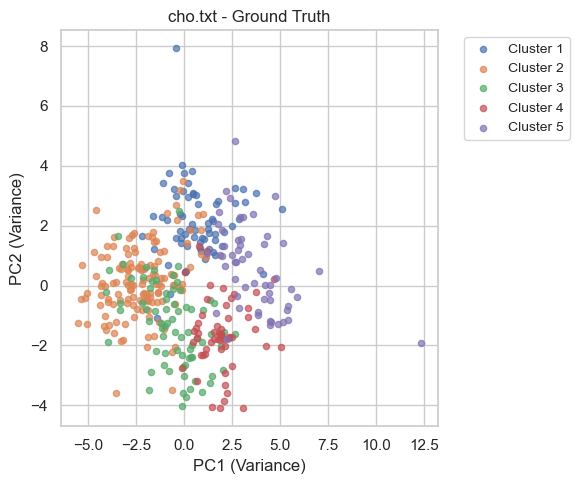

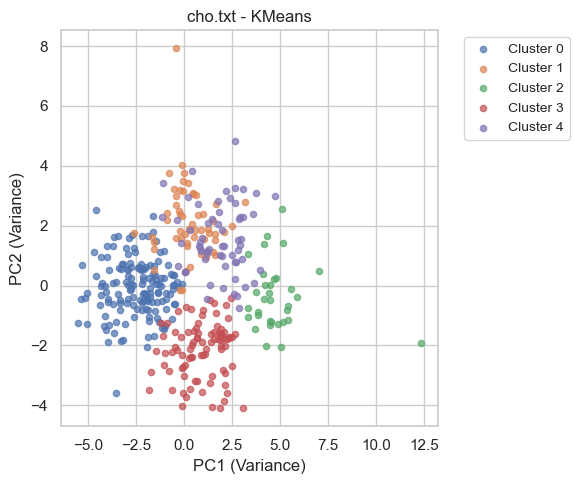

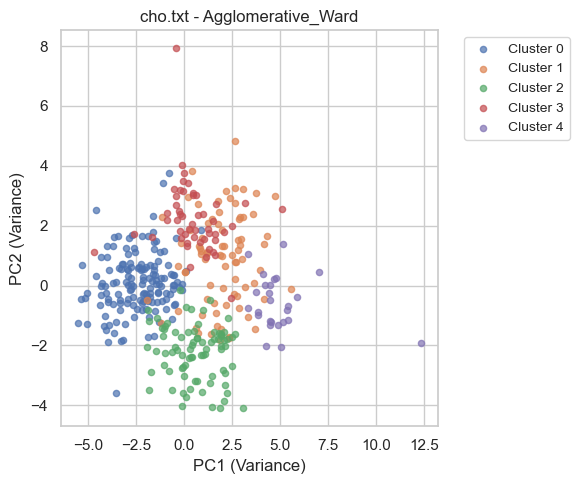

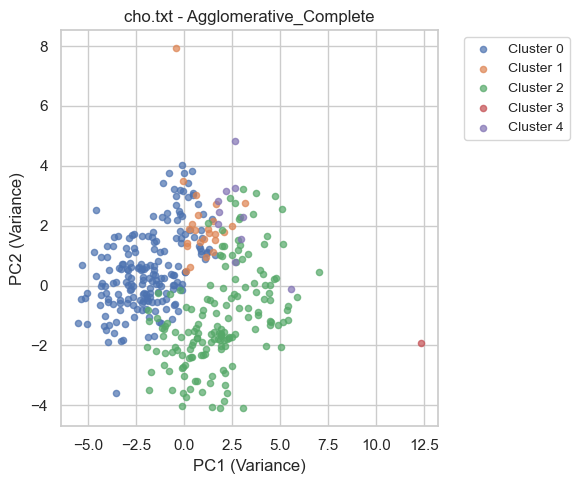

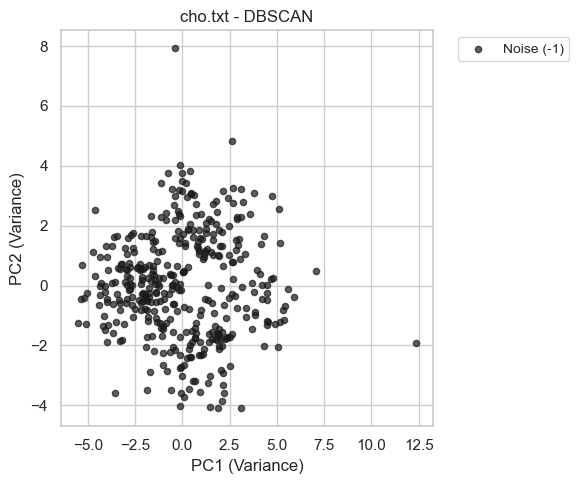

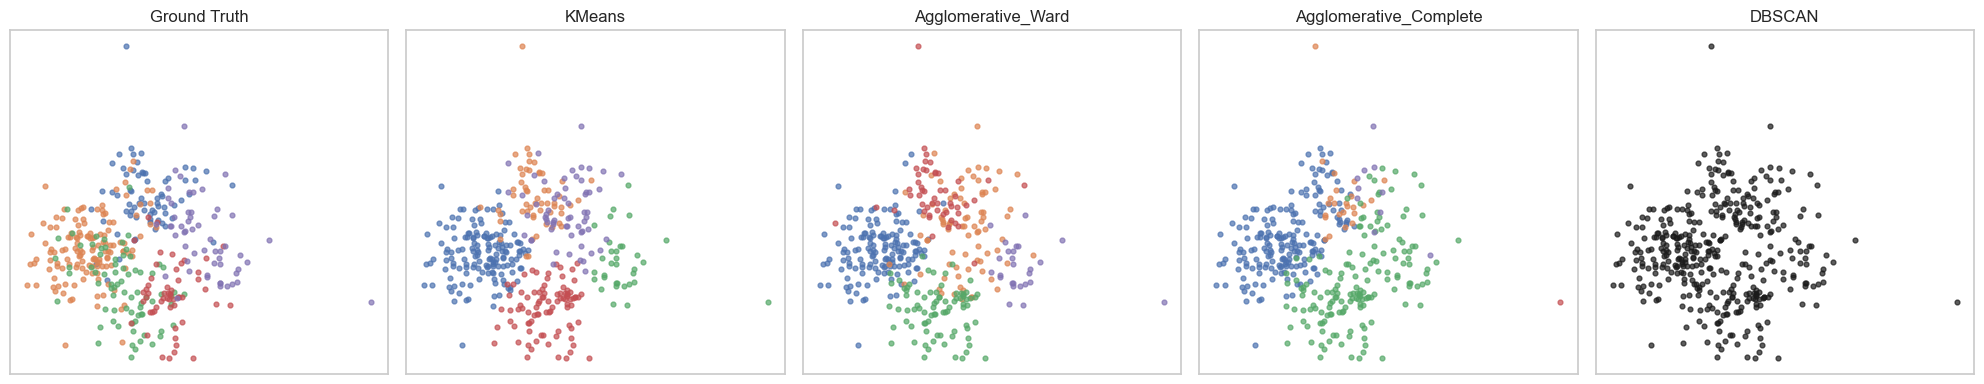


Running Clustering Analysis for iyer.txt


,ARI,NMI,FMI,Silhouette,Clusters Found,Has Noise
Algorithm,,,,,,
KMeans,0.3128,0.4827,0.5255,0.3889,10,False
Agglomerative_Ward,0.3330,0.4793,0.5394,0.3719,10,False
Agglomerative_Complete,0.0580,0.2191,0.4108,0.5333,10,False
DBSCAN,0.2694,0.3863,0.5081,0.4251,5,True


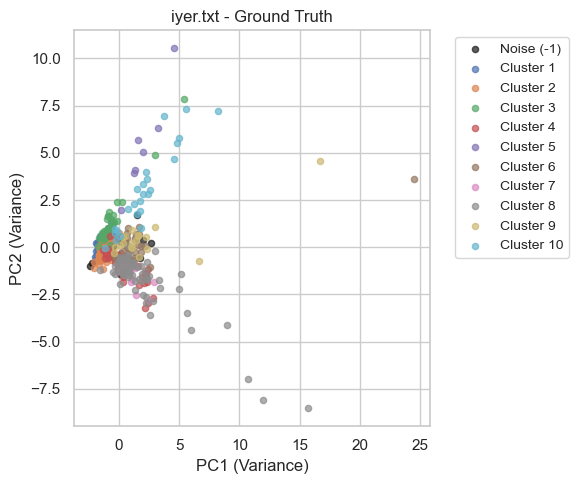

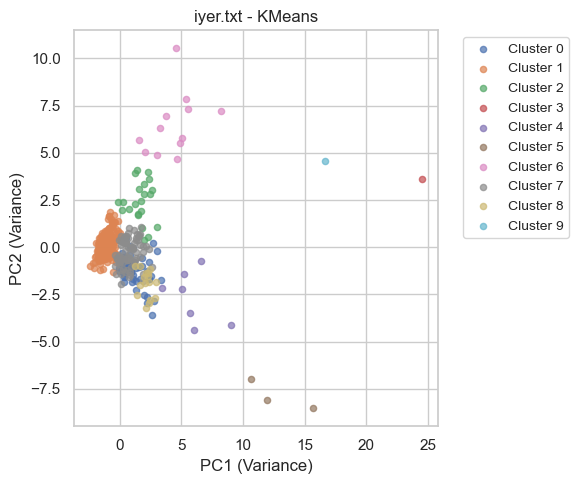

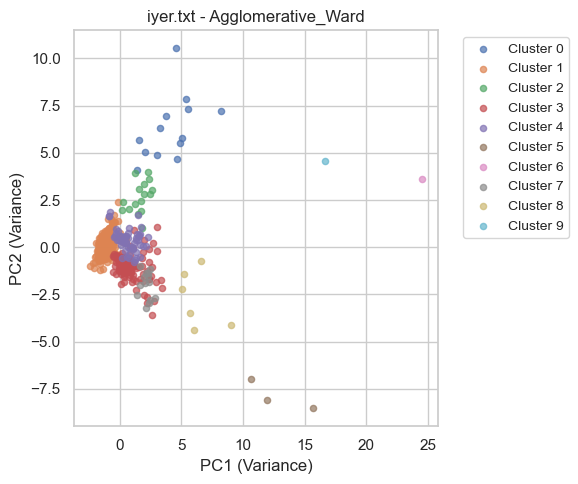

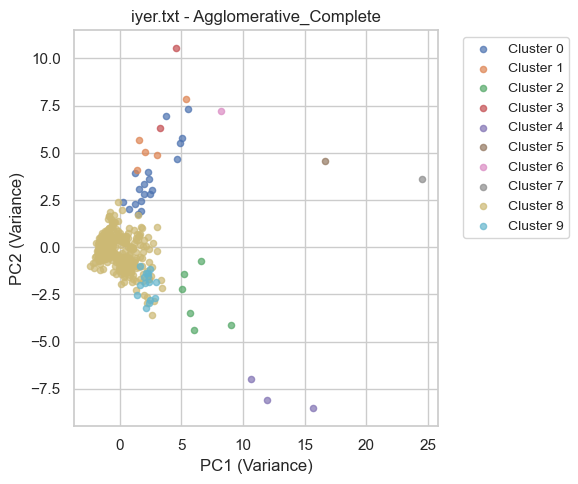

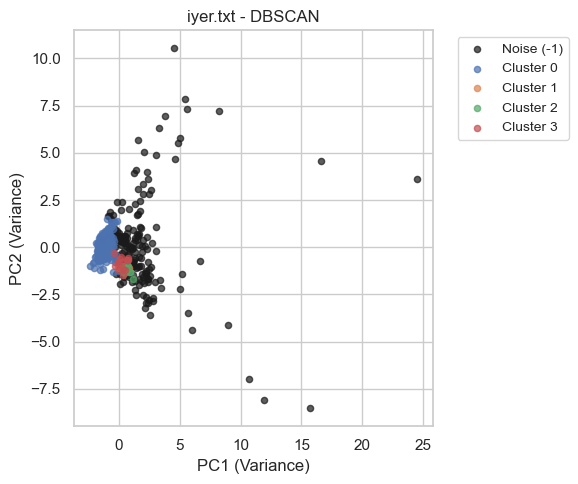

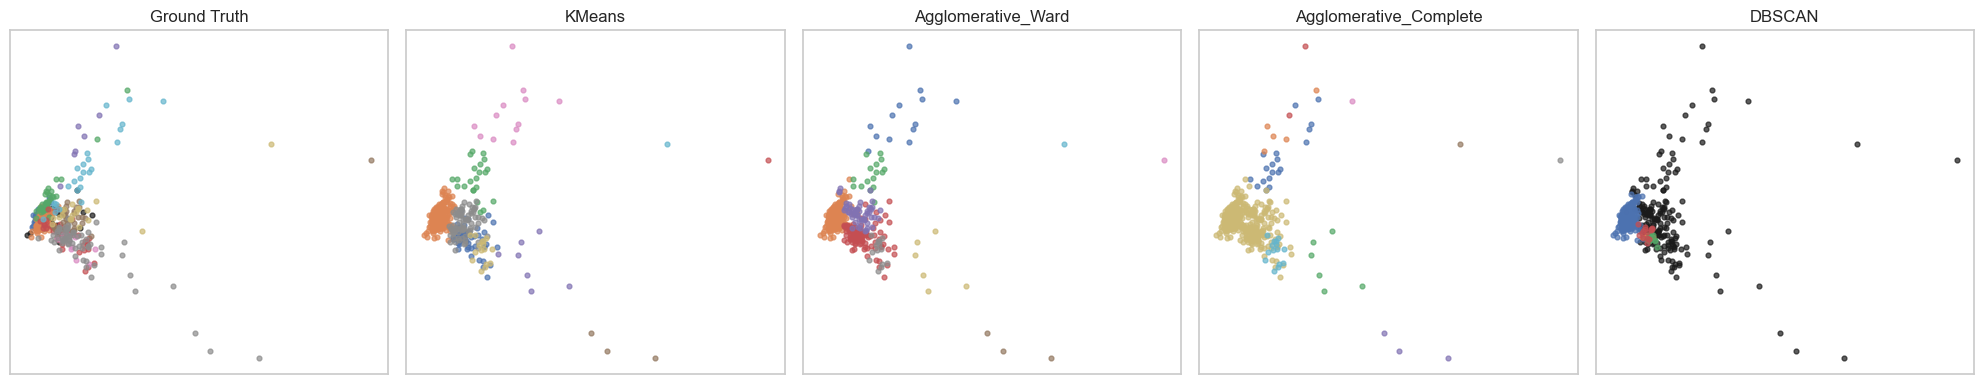

In [17]:
datasets = ["cho.txt", "iyer.txt"]

for dataset_path in datasets:
    print(f"\n{'='*70}\nRunning Clustering Analysis for {dataset_path}\n{'='*70}")
    
    # --- Load dataset ---
    df, X, y_true = load_gene_dataset(dataset_path)
    
    # --- Preprocessing ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # --- Run clustering ---
    true_clusters = len(np.unique(y_true[y_true != -1]))
    cluster_labels = run_clustering_algorithms(X_scaled, true_clusters)
    
    # --- Evaluate results ---
    scores_df = evaluate_clustering(y_true, X_scaled, cluster_labels)
    display(scores_df.round(4))
    
    # --- Plot PCA results ---
    plot_clusters_pca(X_pca, y_true, f"{dataset_path} - Ground Truth", f"out/{dataset_path}_truth.png")
    for name, labels in cluster_labels.items():
        plot_clusters_pca(X_pca, labels, f"{dataset_path} - {name}", f"out/{dataset_path}_{name}.png")
    
    # --- Combined visualization ---
    fig, axes = plt.subplots(1, len(cluster_labels)+1, figsize=(20,4))
    names = ["Ground Truth"] + list(cluster_labels.keys())
    all_labels = [y_true] + list(cluster_labels.values())
    
    for ax, name, labels in zip(axes, names, all_labels):
        unique = np.unique(labels)
        for u in unique:
            mask = labels == u
            color = "k" if u == -1 else None
            ax.scatter(X_pca[mask,0], X_pca[mask,1], s=12, alpha=0.7, c=color)
        ax.set_title(name)
        ax.set_xticks([]); ax.set_yticks([])
    
    plt.tight_layout()
    plt.savefig(f"out/{dataset_path}_all_methods.png", dpi=150)
    plt.show()

In [18]:
from IPython.display import Markdown

summary = """
### 🧬 Gene Expression Clustering Comparison Summary

**Algorithms Used**
- **K-Means**: Fast, assumes spherical clusters, needs k.
- **Hierarchical Agglomerative (Ward, Complete)**: 
  - Ward → minimizes variance (compact clusters).  
  - Complete → resists chaining (more separated clusters).
- **DBSCAN**: Density-based, identifies arbitrary-shaped clusters and outliers (-1).

**Validation Metrics**
- **Adjusted Rand Index (ARI)** — agreement with ground truth, corrected for chance.
- **Normalized Mutual Information (NMI)** — shared information between true and predicted clusters.
- **Fowlkes–Mallows Index (FMI)** — geometric mean of precision and recall.
- **Silhouette** — internal measure of cluster compactness/separation.

**Observations**
- K-Means typically performs well if clusters are roughly spherical and balanced.
- Hierarchical methods (especially Ward) produce meaningful biological groupings.
- DBSCAN can isolate noise points (`-1`) but requires tuning `eps` and `min_samples`.

See `/out/` folder for all PCA visualizations and combined figures.
"""
display(Markdown(summary))



### 🧬 Gene Expression Clustering Comparison Summary

**Algorithms Used**
- **K-Means**: Fast, assumes spherical clusters, needs k.
- **Hierarchical Agglomerative (Ward, Complete)**: 
  - Ward → minimizes variance (compact clusters).  
  - Complete → resists chaining (more separated clusters).
- **DBSCAN**: Density-based, identifies arbitrary-shaped clusters and outliers (-1).

**Validation Metrics**
- **Adjusted Rand Index (ARI)** — agreement with ground truth, corrected for chance.
- **Normalized Mutual Information (NMI)** — shared information between true and predicted clusters.
- **Fowlkes–Mallows Index (FMI)** — geometric mean of precision and recall.
- **Silhouette** — internal measure of cluster compactness/separation.

**Observations**
- K-Means typically performs well if clusters are roughly spherical and balanced.
- Hierarchical methods (especially Ward) produce meaningful biological groupings.
- DBSCAN can isolate noise points (`-1`) but requires tuning `eps` and `min_samples`.

See `/out/` folder for all PCA visualizations and combined figures.
